# IMPORTS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import re
from matplotlib.patches import ConnectionPatch
from pprint import pprint
from sklearn.metrics import average_precision_score
from random import sample

In [2]:
cv2.__version__

'3.4.2'

In [3]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'

# LOAD IMAGES

In [4]:
images = glob.glob(project_root + '/hpatches-sequences-release/v_london/*.ppm')
transformations = glob.glob(project_root + '/hpatches-sequences-release/v_london/H*')

In [5]:
images = sorted(images)
transformations = sorted(transformations)

In [6]:
image_names = [im.split('/')[-1] for im in images]

In [7]:
images

['/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/1.ppm',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/2.ppm',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/3.ppm',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/4.ppm',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/5.ppm',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/6.ppm']

In [8]:
transformations

['/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/H_1_2',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/H_1_3',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/H_1_4',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/H_1_5',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_london/H_1_6']

In [9]:
image_names

['1.ppm', '2.ppm', '3.ppm', '4.ppm', '5.ppm', '6.ppm']

In [10]:
images = [cv2.imread(im) for im in images]

# FIND SIFT KEYPOINTS ON IMAGES

In [11]:
images[0].shape

(914, 1380, 3)

### VIEW IMAGES

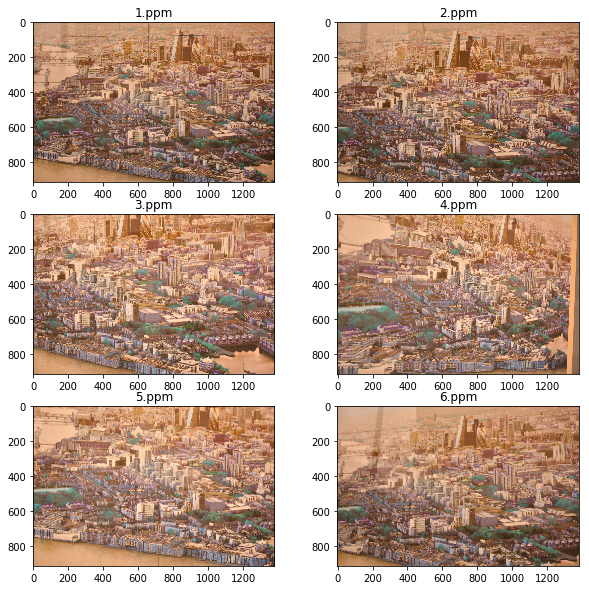

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
for i, axx in enumerate(ax.ravel()):
    axx.imshow(images[i])
    axx.set_title('{}'.format(image_names[i]))
plt.show()

### FIND SIFT KEYPOINTS

In [13]:
keypoint_dict = {}

for id1,img in enumerate(images):
    keypoint_dict[image_names[id1]] = {}
    gray = cv2.cvtColor(img ,cv2.COLOR_RGB2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    keypoint_dict[image_names[id1]]['kp'] = kp
    keypoint_dict[image_names[id1]]['des'] = des

In [14]:
keypoint_dict['1.ppm']['des'].shape

(19291, 128)

In [15]:
keypoint_dict.keys()

dict_keys(['1.ppm', '2.ppm', '3.ppm', '4.ppm', '5.ppm', '6.ppm'])

### VISUALIZE KEYPOINTS

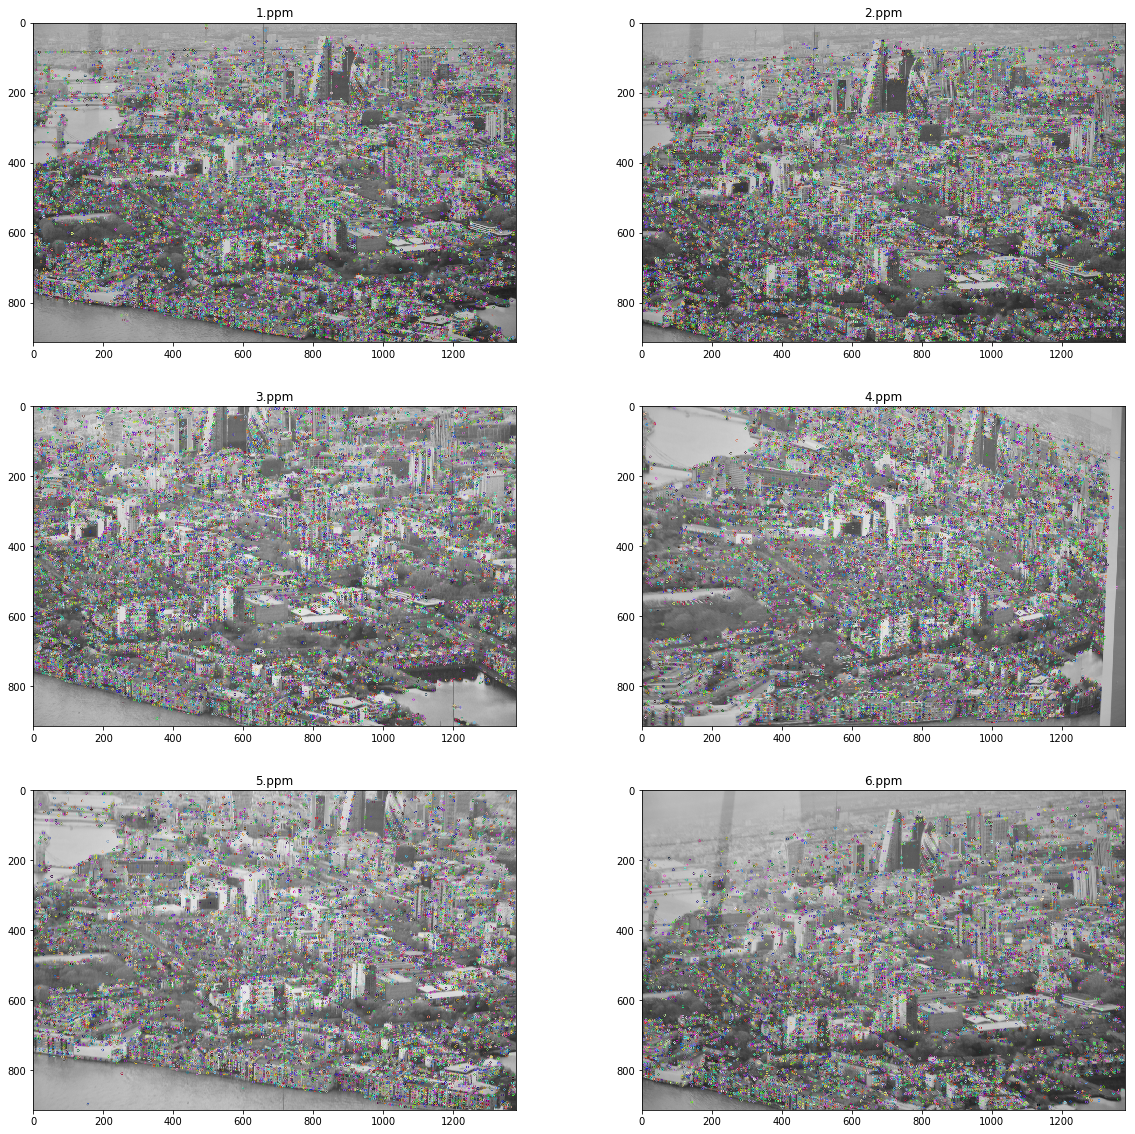

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for id1, axx in enumerate(ax.ravel()):
    
    gray = cv2.cvtColor(images[id1] ,cv2.COLOR_RGB2GRAY)
    gray_with_kp = cv2.drawKeypoints(gray, 
                                     keypoint_dict[image_names[id1]]['kp'], 
                                     cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    
    axx.imshow(gray_with_kp)
    axx.set_title('{}'.format(image_names[id1]))
plt.show()

# REMOVING POINTS THAT ARE NOT COMMON BETWEEN IMAGES

### GET TRANSFORMATION MATRICES

In [17]:
transformations_matrices = []

for transf in transformations:
    with open(transf) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        transformations_matrices.append(np.array(nrs).reshape(3,3).astype(np.float))

In [18]:
transformations_matrices

[array([[ 8.8632e-01, -1.2492e-02, -1.3692e+02],
        [-4.7209e-02,  1.0157e+00,  4.2178e+01],
        [-1.4230e-04,  1.8595e-05,  1.0005e+00]]),
 array([[ 8.6273e-01,  3.0727e-02, -2.5765e+02],
        [-8.1274e-02,  1.0175e+00, -4.8986e+01],
        [-1.6043e-04,  4.4449e-05,  1.0008e+00]]),
 array([[ 2.4144e+00, -2.2023e-03, -1.9930e+02],
        [ 5.2146e-01,  2.0547e+00, -5.6949e+02],
        [ 1.0423e-03,  8.4489e-05,  1.0043e+00]]),
 array([[ 1.3838e+00,  2.4181e-02, -9.3882e+01],
        [ 9.3344e-02,  1.3070e+00, -2.3276e+02],
        [ 1.5995e-04,  6.7546e-05,  1.0008e+00]]),
 array([[ 7.7105e-01, -9.7833e-02, -3.6994e+00],
        [-9.2675e-02,  8.1167e-01,  9.2799e+01],
        [-1.3920e-04, -1.2806e-04,  9.9964e-01]])]

### REMOVE POINTS FORM REF. IMAGE THAT DO NOT APPEAR  ON SEQUENCE IMAGES

In [19]:
len(keypoint_dict['1.ppm']['kp'])

19291

In [20]:
images_size = images[0].shape

In [21]:
images_size

(914, 1380, 3)

In [22]:
# for id1, orig_point in (keypoint_dict['1.ppm']['kp']):
#     point = np.array(keypoint_dict['1.ppm']['kp'][i].pt + (1,)).reshape(3,1)
#     imaged_point = [ np.dot(tr, point) for tr in transformations_matrices ]
#     imaged_point_normal = [ dot/dot[2,0] for dot in imaged_point]
#     [ False for im_point in imaged_point ]

In [23]:
for id1, im in enumerate(images[1:]):
    print('Processing image {}'.format(image_names[id1+1]))
    indexes_to_remove = []
    
    for i in range(len(keypoint_dict['1.ppm']['kp'])):
        point = np.array(keypoint_dict['1.ppm']['kp'][i].pt + (1,)).reshape(3,1)
        imaged_point = np.dot(transformations_matrices[id1], point)
        imaged_point_normal = imaged_point/imaged_point[2,0]
        
        if not ((0 < imaged_point_normal[0,0] and imaged_point_normal[0,0] < images_size[1]) and 
                (0 < imaged_point_normal[1,0] and imaged_point_normal[1,0] < images_size[0])):
            indexes_to_remove.append(i)
    
    print('Removed {} keypoints from the ref images\
           in regards to img {}'.format(len(indexes_to_remove),image_names[id1+1]))
    keypoint_dict['1.ppm']['kp'] = [kp for id1, kp in enumerate(keypoint_dict['1.ppm']['kp']) 
                                    if id1 not in indexes_to_remove]
    keypoint_dict['1.ppm']['des'] = np.delete(keypoint_dict['1.ppm']['des'], indexes_to_remove, 0)

Processing image 2.ppm
Removed 3166 keypoints from the ref images           in regards to img 2.ppm
Processing image 3.ppm
Removed 2008 keypoints from the ref images           in regards to img 3.ppm
Processing image 4.ppm
Removed 282 keypoints from the ref images           in regards to img 4.ppm
Processing image 5.ppm
Removed 814 keypoints from the ref images           in regards to img 5.ppm
Processing image 6.ppm
Removed 0 keypoints from the ref images           in regards to img 6.ppm


In [24]:
len(keypoint_dict['1.ppm']['kp'])

13021

### REMOVE POINTS FROM SEQUENCE  IMAGES THAT DO NOT APPEAR IN  REF. IMAGE

In [25]:
for name in image_names[1:]:
    print('Keypoints in {}: {}'.format(name,len(keypoint_dict[name]['kp'])))

Keypoints in 2.ppm: 19865
Keypoints in 3.ppm: 17279
Keypoints in 4.ppm: 16152
Keypoints in 5.ppm: 12326
Keypoints in 6.ppm: 10346


In [26]:
for id1, name in enumerate(image_names[1:]):
    print('Processing image {}'.format(name))
    indexes_to_remove = []
    
    for id2, point in enumerate(keypoint_dict[name]['kp']):
        point = np.array(point.pt + (1,)).reshape(3,1)
        
        imaged_point = np.dot(np.linalg.inv(transformations_matrices[id1]), point)
        imaged_point_normal = imaged_point/imaged_point[2,0]
        
        if not ((0 < imaged_point_normal[0,0] and imaged_point_normal[0,0] < images_size[1]) and 
                (0 < imaged_point_normal[1,0] and imaged_point_normal[1,0] < images_size[0])):
            indexes_to_remove.append(id2)
    
    print('Removed {} keypoints from the image {}'.format(len(indexes_to_remove),name))
    keypoint_dict[name]['kp'] = [kp for id1, kp in enumerate(keypoint_dict[name]['kp']) 
                                    if id1 not in indexes_to_remove]
    keypoint_dict[name]['des'] =  np.delete(keypoint_dict[name]['des'], indexes_to_remove, 0)

Processing image 2.ppm
Removed 724 keypoints from the image 2.ppm
Processing image 3.ppm
Removed 1992 keypoints from the image 3.ppm
Processing image 4.ppm
Removed 876 keypoints from the image 4.ppm
Processing image 5.ppm
Removed 380 keypoints from the image 5.ppm
Processing image 6.ppm
Removed 177 keypoints from the image 6.ppm


In [27]:
for name in image_names[1:]:
    print('Keypoints in {}: {}'.format(name,len(keypoint_dict[name]['kp'])))

Keypoints in 2.ppm: 19141
Keypoints in 3.ppm: 15287
Keypoints in 4.ppm: 15276
Keypoints in 5.ppm: 11946
Keypoints in 6.ppm: 10169


### VISUALIZE IMAGES

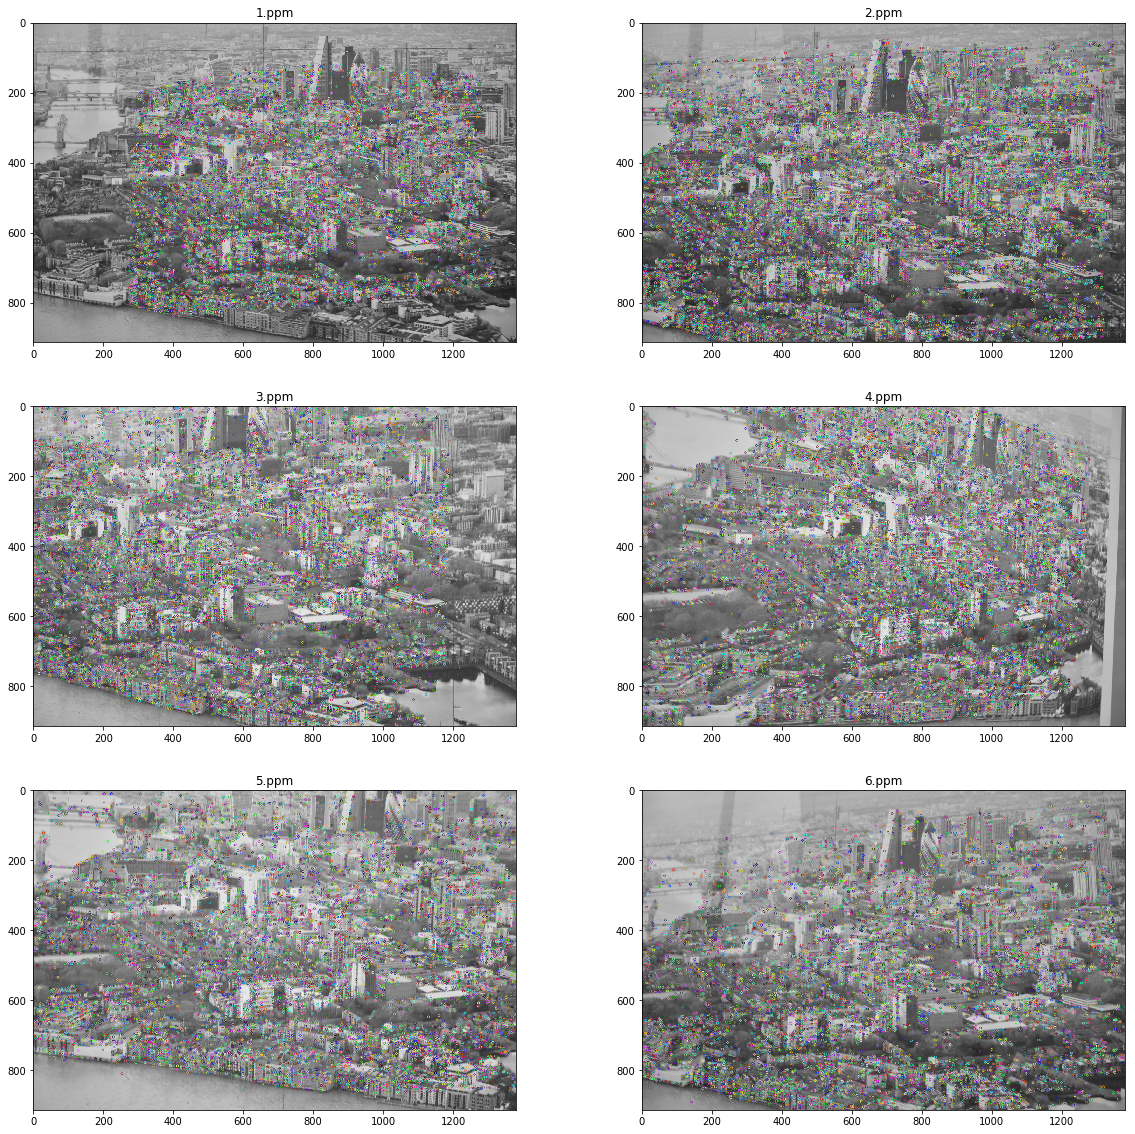

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for id1, axx in enumerate(ax.ravel()):
    
    gray = cv2.cvtColor(images[id1] ,cv2.COLOR_RGB2GRAY)
    gray_with_kp = cv2.drawKeypoints(gray, 
                                     keypoint_dict[image_names[id1]]['kp'], 
                                     cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    
    axx.imshow(gray_with_kp)
    axx.set_title('{}'.format(image_names[id1]))
plt.show()

In [29]:
#  data=[(1, 1), (2, 3), 'r',
#        (2, 2), (4, 5), 'g',
#        (5, 5), (6, 7), 'b',]

# plt.plot(*data)

# IMAGE MATCHING

### GET MATCHES

In [ ]:
image_names[1:]

In [ ]:
matches_with_ref = {}

In [ ]:
for im in image_names[1:]:
    bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
    matches = bf.match(keypoint_dict['1.ppm']['des'], keypoint_dict[im]['des'])
    matches_with_ref[im] = sorted(matches, key = lambda x:x.distance)

### VISUALIZE TOP TEN MATCHES

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30,30))
for i, axx in enumerate(ax.ravel()):
    if (i % 2) == 1:
        continue
        
    points_on_first_img = []
    points_on_second_img = []
    
    axx.imshow(images[0])
    axx.set_title('{}'.format(image_names[0]))
    ax.ravel()[i+1].imshow(images[int(i/2)+1])
    ax.ravel()[i+1].set_title('{}'.format(image_names[int(i/2)+1]))
    
    for m in matches_with_ref[image_names[int(i/2)+1]][:10]:
        points_on_first_img.append(keypoint_dict['1.ppm']['kp'][m.queryIdx].pt)
        points_on_second_img.append(keypoint_dict[image_names[int(i/2)+1]]['kp'][m.trainIdx].pt)
        
    axx.scatter([i[0] for i in points_on_first_img],
                [i[1] for i in points_on_first_img],
                s=20, 
                c='red')
    
    ax.ravel()[i+1].scatter([i[0] for i in points_on_second_img],
                            [i[1] for i in points_on_second_img],
                            s=20, 
                            c='red')
    
    for j in range(len(points_on_first_img)):
        con = ConnectionPatch(xyA=(points_on_second_img[j][0],points_on_second_img[j][1]), 
                              xyB=(points_on_first_img[j][0],points_on_first_img[j][1]),
                              coordsA="data", coordsB="data",
                              axesA=ax.ravel()[i+1], axesB=axx, color="red")
        
        ax.ravel()[i+1].add_artist(con)
    

plt.show()

# PROBA

In [30]:
ind = [0,1,2,3,4]

In [31]:
im = '2.ppm'
bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
em = bf.match(keypoint_dict['1.ppm']['des'][ind], keypoint_dict[im]['des'])

In [32]:
for m in em:
    print(m.queryIdx, m.trainIdx, m.distance)

0 967 187.1683807373047
1 9838 218.44679260253906
2 996 77.68526458740234
3 1001 119.89161682128906
4 1002 127.22028350830078


In [64]:
a = keypoint_dict['1.ppm']['kp'][0]

In [63]:
np.array([(x.pt[0],x.pt[1],x.angle) for x in a])

array([[271.5328064 , 764.81109619, 247.81854248],
       [273.46429443, 784.72808838,   3.39245605]])

In [66]:
a.angle

247.81854248046875

In [52]:
sift_columns = np.array([a.pt[0],a.pt[1], a.angle, a.size, a.response])

In [53]:
sift_columns

array([2.71532806e+02, 7.64811096e+02, 2.47818542e+02, 4.58957291e+00,
       2.71333959e-02])

# EVALUATION

In [34]:
# pretvori matches u numpy array gdje je prvi stupac queryIdx, drugi stupac trainIDx, treci distance
matches_with_ref2 = {}
for name, matches in matches_with_ref.items():
    arr = np.array([[m.queryIdx, m.trainIdx, m.distance] for m in matches])
    matches_with_ref2[name] = arr

### TASK 1: PATCH VERIFICATION

In [292]:
n = 10

In [36]:
random_keypoint_indexes = sample(range(len(keypoint_dict['1.ppm']['kp'])), n)

In [37]:
random_keypoint_indexes

[6913, 396, 11162, 12411, 9499, 11098, 10752, 5466, 5413, 10609]

In [38]:
x = list(np.array(keypoint_dict['1.ppm']['kp'])[random_keypoint_indexes])
x_desc = (keypoint_dict['1.ppm']['des'])[random_keypoint_indexes]

/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.
/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [39]:
x_desc.shape

(10, 128)

In [40]:
x

[<KeyPoint 0x7f6026565c00>,
 <KeyPoint 0x7f602658d750>,
 <KeyPoint 0x7f6026526ae0>,
 <KeyPoint 0x7f60264b9330>,
 <KeyPoint 0x7f602650b960>,
 <KeyPoint 0x7f6026525c00>,
 <KeyPoint 0x7f6026520300>,
 <KeyPoint 0x7f60265518a0>,
 <KeyPoint 0x7f6026550d20>,
 <KeyPoint 0x7f602651dde0>]

In [41]:
x_desc

array([[ 35.,  86.,   4., ...,   0.,  25., 140.],
       [ 87.,  27.,   0., ...,   1.,   0.,   6.],
       [  8.,   6.,   1., ...,   0.,   0.,   0.],
       ...,
       [  1.,  41., 119., ...,   0.,   4., 137.],
       [123., 133.,  15., ...,  16.,   0.,   0.],
       [ 48.,  14.,   6., ...,  31.,   0.,   0.]], dtype=float32)

In [42]:
x_crtano = []
x_crtano_names = []
x_crtano_desc = np.array([])

for id1,name in enumerate(image_names[1:]):
    random_keypoint_indexes = sample(range(len(keypoint_dict[name]['kp'])), int(n/5))
    
    x_crtano += list(np.array(keypoint_dict[name]['kp'])[random_keypoint_indexes])
    x_crtano_names += [name]*len(random_keypoint_indexes)
    if id1 == 0:
        x_crtano_desc = (keypoint_dict[name]['des'])[random_keypoint_indexes]
    else:
        x_crtano_desc = np.concatenate((x_crtano_desc, 
                                        (keypoint_dict[name]['des'])[random_keypoint_indexes] ),axis=0)

/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional ind

In [43]:
x_crtano

[<KeyPoint 0x7f6020077de0>,
 <KeyPoint 0x7f6020085d80>,
 <KeyPoint 0x7f601b771e70>,
 <KeyPoint 0x7f601b751690>,
 <KeyPoint 0x7f601b6935d0>,
 <KeyPoint 0x7f601b6b3390>,
 <KeyPoint 0x7f601b5d2450>,
 <KeyPoint 0x7f601b639030>,
 <KeyPoint 0x7f601b594cf0>,
 <KeyPoint 0x7f601b5a9750>]

In [44]:
x_crtano_names

['2.ppm',
 '2.ppm',
 '3.ppm',
 '3.ppm',
 '4.ppm',
 '4.ppm',
 '5.ppm',
 '5.ppm',
 '6.ppm',
 '6.ppm']

In [45]:
x_crtano_desc

array([[  4.,  23., 120., ...,  31.,  10.,   1.],
       [  0.,   1.,   7., ...,  43., 127.,  37.],
       [ 91.,   8.,   0., ...,  21.,   2.,  10.],
       ...,
       [  2., 107., 122., ...,   1.,  21.,  17.],
       [  4.,   4.,  32., ...,  36.,  37.,  11.],
       [ 16.,  64.,  85., ...,  11.,  32.,   7.]], dtype=float32)

In [46]:
if len(x_crtano) != n:
    random_image = sample(image_names[1:], 1)
    x_crtano.append(sample(keypoint_dict[random_image]['kp'], 1)[0])
    x_crtano_names.append(random_image)

In [47]:
y = []
s = []

for id1, point2 in enumerate(x_crtano):
    # prvo ces provjeravat da li je slika iz iste sekvence nekako? Zasad je pa moras preslikat tocku
    
    # pronadji H
    matrix_index = int(x_crtano_names[id1].split('.')[0])-2
    H = transformations_matrices[matrix_index]
    
    # preslikaj tocku
    point1 = np.array(x[id1].pt + (1,)).reshape(3,1)
    imaged_point = np.dot(H, point1)
    imaged_point_normalized = imaged_point/imaged_point[2,0]
    
    # udaljenost preslikane tocke i x_crtano
    dist = np.linalg.norm(np.array(point2.pt).reshape(2,1) - imaged_point_normalized[:2,:])
    
    label = None

    # provjerit da li je medju svim keypointovima na slici 2, x' najblizi Hx
    for kp in keypoint_dict[x_crtano_names[id1]]['kp']:
        if (np.linalg.norm(np.array(kp.pt).reshape(2,1) - imaged_point_normalized[:2,:])) < dist:
            if kp.pt == point2.pt:
                continue
            label = -1
            y.append(label)
            break
    
    if not label:
         y.append(1)
            
    # usporedit deskriptore
    s.append(np.linalg.norm(x_desc[id1,:] - x_crtano_desc[id1,:]))  
    
    

In [48]:
y

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [49]:
s

[545.80493,
 582.53925,
 421.28375,
 487.0688,
 539.649,
 563.0915,
 555.68787,
 411.13867,
 516.1143,
 600.4773]

In [50]:
# ranked_list = sorted(range(len(s)), key=lambda k: s[k])

In [51]:
# [y[i] for i in ranked_list]

In [52]:
average_precision_score(y,s)

/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


nan

### TASK 1: PATCH VERIFICATION (NAMJESTIT SI DA IMAMO POZITIVNIH MATCHEVA)

In [293]:
fixed_keypoint_indexes = [0,1,2,3,4,5,6,7,8,9]

In [294]:
x = list(np.array(keypoint_dict['1.ppm']['kp'])[fixed_keypoint_indexes])
x_desc = (keypoint_dict['1.ppm']['des'])[fixed_keypoint_indexes]

In [295]:
x_crtano = []
x_crtano_names = []
x_crtano_desc = np.array([])

for id1,name in enumerate(image_names[1:]):
    random_keypoint_indexes = sample(range(len(keypoint_dict[name]['kp'])), int(n/5))
    
    x_crtano += list(np.array(keypoint_dict[name]['kp'])[random_keypoint_indexes])
    x_crtano_names += [name]*len(random_keypoint_indexes)
    if id1 == 0:
        x_crtano_desc = (keypoint_dict[name]['des'])[random_keypoint_indexes]
    else:
        x_crtano_desc = np.concatenate((x_crtano_desc, 
                                        (keypoint_dict[name]['des'])[random_keypoint_indexes] ),axis=0)

In [296]:
# pronadi 2 matcha za prva 2 indeksa
print(matches_with_ref2['2.ppm'][matches_with_ref2['2.ppm'][:,0] == 0])
print(matches_with_ref2['2.ppm'][matches_with_ref2['2.ppm'][:,0] == 1])

[[  0.         967.         187.16838074]]
[[1.00000000e+00 9.83800000e+03 2.18446793e+02]]


In [297]:
x_crtano[0] = keypoint_dict['2.ppm']['kp'][967]
x_crtano[1] = keypoint_dict['2.ppm']['kp'][9838]

In [298]:
x_crtano_desc[[0,1],:] = (keypoint_dict['2.ppm']['des'])[[967,9838]]

In [303]:
x_crtano_desc.shape

(10, 128)

In [299]:
y = []
s = []

for id1, point2 in enumerate(x_crtano):
    # prvo ces provjeravat da li je slika iz iste sekvence nekako? Zasad je pa moras preslikat tocku
    
    # pronadji H
    matrix_index = int(x_crtano_names[id1].split('.')[0])-2
    H = transformations_matrices[matrix_index]
    
    # preslikaj tocku
    point1 = np.array(x[id1].pt + (1,)).reshape(3,1)
    imaged_point = np.dot(H, point1)
    imaged_point_normalized = imaged_point/imaged_point[2,0]
    
    # udaljenost preslikane tocke i x_crtano
    dist = np.linalg.norm(np.array(point2.pt).reshape(2,1) - imaged_point_normalized[:2,:])
    
    label = None

    # provjerit da li je medju svim keypointovima na slici 2, x' najblizi Hx
    for kp in keypoint_dict[x_crtano_names[id1]]['kp']:
        if (np.linalg.norm(np.array(kp.pt).reshape(2,1) - imaged_point_normalized[:2,:])) < dist:
            if kp.pt == point2.pt:
                continue
            label = -1
            y.append(label)
            break
    
    if not label:
         y.append(1)
            
    # usporedit deskriptore
    s.append(np.linalg.norm(x_desc[id1,:] - x_crtano_desc[id1,:]))  
    
    

In [300]:
y

[1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [68]:
s = [-s_ for s_ in s]

In [69]:
s

[-187.16838,
 -218.4468,
 -576.94885,
 -539.459,
 -607.6586,
 -620.15967,
 -503.02884,
 -560.8547,
 -428.82397,
 -482.56088]

In [70]:
average_precision_score(y,s)

1.0

# TASK 1: PATCH VERIFICATION (GENERALIZACIJA)

In [ ]:
y = []
s = []

for id1, point2 in enumerate(x_crtano):
    # prvo ces provjeravat da li je slika iz iste sekvence nekako? Zasad je pa moras preslikat tocku
    
    # pronadji H
    matrix_index = int(x_crtano_names[id1].split('.')[0])-2
    H = transformations_matrices[matrix_index]
    
    # preslikaj tocku
    point1 = np.array(x[id1].pt + (1,)).reshape(3,1)
    imaged_point = np.dot(H, point1)
    imaged_point_normalized = imaged_point/imaged_point[2,0]
    
    # udaljenost preslikane tocke i x_crtano
    dist = np.linalg.norm(np.array(point2.pt).reshape(2,1) - imaged_point_normalized[:2,:])
    
    label = None

    # provjerit da li je medju svim keypointovima na slici 2, x' najblizi Hx
    for kp in keypoint_dict[x_crtano_names[id1]]['kp']:
        if (np.linalg.norm(np.array(kp.pt).reshape(2,1) - imaged_point_normalized[:2,:])) < dist:
            if kp.pt == point2.pt:
                continue
            label = -1
            y.append(label)
            break
    
    if not label:
         y.append(1)
            
    # usporedit deskriptore
    s.append(np.linalg.norm(x_desc[id1,:] - x_crtano_desc[id1,:]))  
    
    

# TASK 2: IMAGE MATCHING

In [413]:
n = 10

In [414]:
random_keypoint_indexes = sample(range(len(keypoint_dict['1.ppm']['kp'])), n)

In [415]:
random_keypoint_indexes

[1853, 7884, 9478, 7537, 3725, 3707, 9943, 6780, 1362, 9]

In [416]:
x = list(np.array(keypoint_dict['1.ppm']['kp'])[random_keypoint_indexes])
x_desc = (keypoint_dict['1.ppm']['des'])[random_keypoint_indexes]

In [417]:
x

[<KeyPoint 0x7f60265a0840>,
 <KeyPoint 0x7f60264f2d20>,
 <KeyPoint 0x7f602650b3f0>,
 <KeyPoint 0x7f60264edf30>,
 <KeyPoint 0x7f60265397b0>,
 <KeyPoint 0x7f6026539390>,
 <KeyPoint 0x7f6026513600>,
 <KeyPoint 0x7f6026563de0>,
 <KeyPoint 0x7f602659a150>,
 <KeyPoint 0x7f6026587750>]

In [418]:
x_desc

array([[ 24.,  29.,  28., ...,  10.,   6.,   7.],
       [ 26.,  17.,   4., ...,  44.,  17.,   0.],
       [ 26.,  17.,   6., ...,   6.,  11.,   3.],
       ...,
       [116.,  84.,   4., ...,  30.,  10.,  14.],
       [ 37.,  65.,   3., ...,  10.,   6.,   2.],
       [  2.,   4.,   9., ...,   0.,   2.,  36.]], dtype=float32)

In [419]:
# NAMJESTAVANJE
fixed_keypoint_indexes = [0,1,2,3,4,5,6,7,8,9]

x = list(np.array(keypoint_dict['1.ppm']['kp'])[fixed_keypoint_indexes])
x_desc = (keypoint_dict['1.ppm']['des'])[fixed_keypoint_indexes]

In [420]:
x_crtano = []
x_crtano_names = []
x_crtano_desc = np.array([])

for id1,name in enumerate(image_names[1:]):
    random_keypoint_indexes = sample(range(len(keypoint_dict[name]['kp'])), n)
    
    x_crtano += list(np.array(keypoint_dict[name]['kp'])[random_keypoint_indexes])
    x_crtano_names += [name]*len(random_keypoint_indexes)
    if id1 == 0:
        x_crtano_desc = (keypoint_dict[name]['des'])[random_keypoint_indexes]
    else:
        x_crtano_desc = np.concatenate((x_crtano_desc, 
                                        (keypoint_dict[name]['des'])[random_keypoint_indexes] ),axis=0)

In [421]:
x_crtano[:5]

[<KeyPoint 0x7f60264e8900>,
 <KeyPoint 0x7f6020032f00>,
 <KeyPoint 0x7f60200a2480>,
 <KeyPoint 0x7f6020037270>,
 <KeyPoint 0x7f602008e3f0>]

In [422]:
x_crtano_names[:5]

['2.ppm', '2.ppm', '2.ppm', '2.ppm', '2.ppm']

In [423]:
x_crtano_desc

array([[ 41.,  18.,  13., ...,  16.,   0.,   2.],
       [ 65.,  37.,  22., ...,   5.,  10.,  80.],
       [ 58.,  20.,   5., ...,  22.,  37.,   0.],
       ...,
       [111., 129.,   1., ...,   3.,   7.,   3.],
       [  1.,   1.,  10., ...,  35.,  43.,  33.],
       [  2.,   0.,   0., ...,  39.,   1.,   1.]], dtype=float32)

In [431]:
# NAMJESTAVANJE
x_crtano[0] = keypoint_dict['2.ppm']['kp'][967]
x_crtano[1] = keypoint_dict['2.ppm']['kp'][9838]

x_crtano_desc[[0,1],:] = (keypoint_dict['2.ppm']['des'])[[967,9838]]

In [398]:
# a = []
# imp = np.dot(transformations_matrices[0] ,np.array(keypoint_dict['1.ppm']['kp'][0].pt+(1,)).reshape(3,1))
# imp_n = imp/imp[2,:]

In [404]:
# a = []
# imp = np.dot(transformations_matrices[0] ,np.array(keypoint_dict['1.ppm']['kp'][0].pt+(1,)).reshape(3,1))
# imp_n = imp/imp[2,:]
# for kp in keypoint_dict['2.ppm']['kp']:
#     a.append(np.linalg.norm(np.array(kp.pt)-imp_n[:2]))
# np.argmin(a)

In [434]:
s = []
y = []
x_points = [x_.pt + (1,) for x_ in x]

for i in range(5):
    
    print('{}-{}'.format(n*i,n*(i+1)))
    print('############')
    
    # match selected keypoints
    bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
    matches = bf.match(x_desc, x_crtano_desc[n*i:n*(i+1)])
    
    for m in matches:
        print(m.queryIdx,m.trainIdx,m.distance)
    
    # pretvori matches u numpy array gdje je prvi stupac queryIdx, drugi stupac trainIDx, treci distance
    #matches_np = np.array([[m.queryIdx, m.trainIdx, m.distance] for m in matches])
    
    # lista matchanih keypointova na drugoj slici, indexi odgovaraju listi x
    matched_keypoints = [m.trainIdx for m in matches]
    #print(matched_keypoints)
    matched_keypoints = [x_crtano[n*i:n*(i+1)][j] for j in matched_keypoints]
    
    # mjera s
    #s += list(matches_np[:,2])
    s += [m.distance for m in matches]
    
    # calculate y
    H = transformations_matrices[i]
    
    # preslikaj tocke sa ref slike na  (svaki stupac je jedna preslikana tocka)
    # mnozis 3x3 matricu H sa 3xn matricom tocaka
    imaged_points = np.dot(H ,np.array(x_points).T)
    imaged_points_normalized = imaged_points/imaged_points[2,:]
    print(imaged_points_normalized)
    
    # compute distances between imaged point Hx and matched keypoint with x on 2.nd image
    distances = [np.linalg.norm(np.array(matched_keypoints[j].pt).reshape(2,1) - 
                                imaged_points_normalized[:2,j]) for j in range(len(matched_keypoints))]
    
    print(distances)
    
    # provjerit da li je medju svim keypointovima na slici 2, x' najblizi Hx
    temporary_label = [0]*n
    
    for kp in keypoint_dict[image_names[i+1]]['kp']:
        if 0 not in temporary_label:
            break
        
        # distance between Hx and current keypoint
        dist = np.array([kp.pt]*n).T - imaged_points_normalized[:2,:]
        print(np.array([kp.pt]*n).T)
        print(imaged_points_normalized[:2,:])
        print('#############################')
        print(dist)
        for j in range(len(distances)):
            if np.linalg.norm(dist[:,j]) < distances[j]:
                print(j)
                print(np.linalg.norm(dist[:,j]),' manja od ',distances[j])
                temporary_label[j] = -1
    
    if 0 in temporary_label:
        print(' A USA SAM')
        ind = list(np.where(np.array(temporary_label) == 0)[0])
        for j in ind:
            temporary_label[j] = 1
            
    y += temporary_label    

0-10
############
0 0 187.1683807373047
1 1 218.44679260253906
2 0 414.8421325683594
3 3 396.9974670410156
4 3 387.9832458496094
5 7 391.0370788574219
6 5 426.0117492675781
7 3 474.91473388671875
8 3 500.499755859375
9 5 399.54974365234375
[[ 96.49894605  97.98832313  98.51576403  98.15152686  98.16487496
   99.56116605 100.41518259 100.41518259 100.41518259 101.19380951]
 [825.93203117 846.48117599 820.07489486 851.83998155 858.8723432
  820.09855366 770.8144233  770.8144233  770.8144233  758.20024948]
 [  1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.        ]]
[1031.4753884900197, 833.5283822050483, 1025.9257290944126, 1079.9661766305037, 1080.823999905651, 1357.0518782995862, 817.177620402048, 1073.5820205799823, 1073.5820205799823, 810.9839231886106]
[[  2.26212049   2.26212049   2.26212049   2.26212049   2.26212049
    2.26212049   2.26212049   2.26212049   2.26212049   2.26212049]
 [509.3493042  509.3493042  509.

In [426]:
s[:10]

[468.264892578125,
 218.44679260253906,
 439.2607421875,
 396.9974670410156,
 387.9832458496094,
 391.0370788574219,
 426.0117492675781,
 474.91473388671875,
 488.42401123046875,
 399.54974365234375]

In [428]:
1 in y

False

In [ ]:
# napraviti za sve slike i sljepiti to u jednu listu onda
# average_precision_score(y_all,s_all)

## ZANEMARI OVO ISPOD

In [43]:
match_errors = {}

In [84]:
match_errors = {}
for name in image_names[1:]:
    match_errors[name] = {}

for id1, point in enumerate(keypoint_dict['1.ppm']['kp']):
    point = np.array(point.pt + (1,)).reshape(3,1)
    imaged_point = [ np.dot(tr, point) for tr in transformations_matrices]
    imaged_point_normalized = [ dot/dot[2,0] for dot in imaged_point]
    imaged_point_normalized = dict(zip(image_names[1:], imaged_point_normalized))
    
    match_errors[name] = {}
    
    for name in image_names[1:]:
        match_errors[name] = {}
        match_errors[name][id1] = None
        for m in matches_with_ref[name]:
            if m.queryIdx == id1 :
                match_errors[name][id1] = np.linalg.norm(np.array(keypoint_dict[name]['kp'][m.trainIdx].pt).reshape(2,1) -
                                                        imaged_point_normalized[name][:2,:])
                break
    
        if not match_errors[name][id1]:
            print('THERE ARE NO MATCHES FOR KEYPOINT {} IN IMAGE {}'.format(id1,name))
            match_errors[name][id1] = -1

In [85]:
match_errors

{'2.ppm': {13020: 0.762491354973777},
 '3.ppm': {13020: 77.02377497995784},
 '4.ppm': {13020: 726.4172042677012},
 '5.ppm': {13020: 142.6432665613596},
 '6.ppm': {13020: 0.3975384748628021}}

In [29]:
bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)

In [30]:
matches = bf.match(keypoint_dict['1.ppm']['des'], keypoint_dict['2.ppm']['des'])

In [34]:
matches[1].distance

302.1953125

In [35]:
matches = sorted(matches, key = lambda x:x.distance)

In [49]:
matches[1].distance

22.956480026245117

In [72]:
a = matches[0]

In [71]:
img3 = cv2.drawMatches(images[0],
                       keypoint_dict['1.ppm']['kp'],
                       images[1],
                       keypoint_dict['2.ppm']['kp'],
                       matches, 
                       None)

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/features2d/src/draw.cpp:211: error: (-215:Assertion failed) i1 >= 0 && i1 < static_cast<int>(keypoints1.size()) in function 'drawMatches'


In [42]:
img3 = cv2.drawMatches(images[0],keypoint_dict['1.ppm']['kp'],images[1],keypoint_dict['2.ppm']['kp'], matches[:10],)

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/features2d/src/draw.cpp:211: error: (-215:Assertion failed) i1 >= 0 && i1 < static_cast<int>(keypoints1.size()) in function 'drawMatches'
